# Eure Netzwerkanalyse auf Basis von Telegram-Daten

Wir importieren die Libraries, die wir für die Netzwerkanalyse benötigen. <br>
<i>Zur Erinnerung: Mit der Nutzung von Libraries sparen wir uns Programmieraufwand, weil wir bereits fertige Komponenten nutzen können.</i>

In [1]:
import pandas as pd # eine Library, die uns dabei hilft Daten vorzubereiten
import networkx as nx # eine Library, die auf Netzwerkanalyse spezialisiert ist
import openpyxl # eine Library, die mit Excel-Dateien umgehen kann
import matplotlib # eine Library, die auf Visualisierungen spezialisiert ist
import scipy

Wir beginnen außerhalb vom Jupyter Notebook. Bitte exportiert Euren csv-File aus dem Telegram Monitoring. <br> <br>
Im nächsten Schritt importieren wir Euren csv-File. 

In [2]:
file_name='Armenien_Telegram.csv'
df = pd.read_csv(file_name,sep=";")

Jetzt schauen wir uns die ersten 5 Zeilen der importierten Daten an:

In [ ]:
df.head()

Aber wie groß ist das Dataset? Wie viele Zeilen? Wie viele Spalten?

In [ ]:
df.shape

Wie kommen wir jetzt zu einer Kantenliste? Wir erinnern uns, dass eine Kantenliste wie folgt aufgebaut ist: <br>
| Knoten 1 | Knoten 2 | Attribut |
|----------|----------|----------|
| Knoten X  | Knoten Y  | Eigenschaft der Verbindung  |
| Knoten X  | Knoten Z  | Eigenschaft der Verbindung |
| Knoten Y  | Knoten Z  | Eigenschaft der Verbindung |

Wie kriegen wir unser Dataframe in diese Form? Zunächst müssen wir die Knoten identifizieren.<br>
Wir werden uns heute auf Verbindungen (=Kanten) konzentrieren, die durch die Weiterleitung von Nachrichten entstanden sind.<br><br>Bedeutet:<br>Eine weitergeleitete Nachricht stellt eine Kante dar. <br>Der Kanal, in dem die Nachricht weitergeleitet wurde, + der Kanal, aus dem eine Nachricht weitergeleitet wurde, stellen die Knoten dar.

Lasst uns nochmal die ersten 5 Zeilen unseres Datasets anschauen, um zu überlegen wie weit wir von einer Kantenliste weg sind?

In [ ]:
# Weißt du noch wie? Sonst kannst du oben spicken

Wir stellen fest, dass der Export aus dem Telegram Monitoring einer Kantenliste schon ziemlich ähnlich sieht:<br>
* Eine Zeile je Nachricht - sprich eine Zeile je Kante --> das passt schon mal! Aber es wurde ja nicht jede Nachricht weitergeleitet? Diese Nachrichten müssen wir bereinigen.
* Die Spalte <i>channel_name</i> stellt den ersten Knoten dar - nämlich den Kanal der die Nachricht weiterleitet.
* Zu dem 2. Knoten, dem Kanal aus dem die Nachricht weitergeleitet wurde, haben wir nur eine ID: <i>forward_channel_id</i>

Als erstes bereinigen wir das Dataframe, um die nicht weitergeleiteten Nachrichten.


In [3]:
df_forwards=df.dropna(subset=['forward_channel_id']) #die Methode "droppt" alle Zeieln mit einer leeren forward_channel_id

Um unser Netzwerk nachher schön darzustellen wäre auch der Name zum 2. Knoten wichtig. Glücklicherweise steht ein 2. csv-file parat, der uns dabei helfen wird den Kanal-Namen zur ID zuzuordnen. Diesen File importieren wird:

In [4]:
file_name2='telegram_channels.csv'
#weißt du noch, wie wir einen csv-file importieren können? Bitte nenne das Dataframe "df_channels"

In [5]:
df_channels = pd.read_csv(file_name2)

In [ ]:
df_channels.head()

Das verbinden von 2 Tabellen wird in der Regel als Join bezeichnet. <br>Die <i>telegram_id</i> entspricht der <i>forward_channel_id</i>. Die <i>description</i> entspricht dem <i>channel_name</i>.<br><br>

Wir müssen also die beiden Dataframes mithilfe der ids joinen, um die Kantenliste um die <i>description</i> zu erweitern. <br> Wir nutzen die Gelegenheit und benennen das Dataframe zur "Kantenliste" um. 

In [6]:
kantenliste=pd.merge(df_forwards, df_channels, left_on='forward_channel_id', right_on='telegram_id', how='inner')

Wie groß ist unsere Kantenliste nun?

In [ ]:
kantenliste.shape

Den ganz Aufmerksamen könnte jetzt auffallen, dass wir einige Nachrichten verloren haben - die Nachrichten, die aus nicht deutschsprachigen Kanälen weitergeleitet wurden, die wir nicht ins Crawling mit aufnehmen.<br><br>Für unsere benötigen wir selbstverständlich keine 22 Spalten. In der folgenden Liste, kannst du definieren, welche Spalten du mit in die Netzwerkanalyse nehmen möchtest. Im nächsten Schritt werden wir dann die Kantenliste auf erwähnten Spalten begrenzen.

In [ ]:
spalten=["channel_name"]
# Der channel_name reicht noch nicht. Ergänze die weiteren Spalten mit einem Komma getrennt. 

In [7]:
spalten=["channel_name","description"]

Jetzt begrenzen wir die Kantenliste auf die gewählten Spalten.

In [8]:
kantenliste=kantenliste[spalten]
kantenliste.head()

,channel_name,description
0,FSN - The Revolution,🔰 Militär-News
1,Q COLOGNE 🕊🔊,🔰 Militär-News
2,Q COLOGNE 🕊🔊,🔰 Militär-News
3,Vivoterra,🔰 Militär-News
4,Frieden Wahrheit Freiheit Wollen Wir 🕊 ❤️,🔰 Militär-News


Jetzt erzeugen wir mithilfe unserer Kantenliste einen Graph namens "G". Ein Graph ist noch nicht die Visualisierung selbst, beinhaltet bereits aber diverse Informationen, die für die Visualisierung notwendig sind.

In [15]:
G = nx.from_pandas_edgelist(kantenliste[0:1000], source='description', target='channel_name')

Jetzt wählen wir ein Layout, das für die Visualisierung noch einen notwendigen Parameter darstellt. Das Spring-Layout ist ein guter Start.<br><br>
Wer später nochmal mit anderen Layouts experimentieren möchte, hier ein Link zur Doku: <br>
https://networkx.org/documentation/stable/reference/drawing.html

In [10]:
print("networkx version:", nx.__version__)
print("scipy version:", scipy.__version__)

networkx version: 3.2.1
scipy version: 1.8.1


In [16]:
pos = nx.spring_layout(G)

Im nächsten Schritt erstellen wir die Visualisierung. Die erste Zeile erzeugt die Knoten und die zweite Zeile die Kanten.

/home/matitz90/miniconda3/envs/d4t/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128304 (\N{JAPANESE SYMBOL FOR BEGINNER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/matitz90/miniconda3/envs/d4t/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128330 (\N{DOVE OF PEACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/matitz90/miniconda3/envs/d4t/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/matitz90/miniconda3/envs/d4t/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/matitz90/miniconda3/envs/d4t/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127756 (\N{MILK

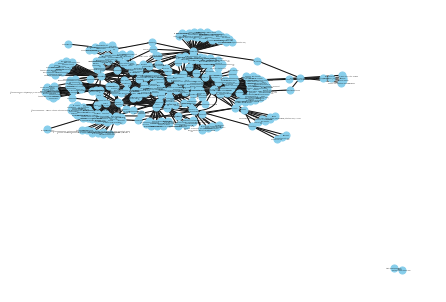

In [18]:
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', font_size=1, font_color='black')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=0.1, edge_color='gray')

Hier findet ihr die Dokumentation von networkx, wie ihr die Visualisierung anpassen könnt:<br>
https://networkx.org/documentation/stable/reference/drawing.html

Wir errechnen die Zentralitätsmaße des Netzwerks. Zunächst für die Knoten.

In [ ]:
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

Wir speichern die Ergebnisse in einem Pandas Dataframe.

In [ ]:
data = {
    'Node': list(G.nodes()),
    'Degree Centrality': list(degree_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values())
}

df_kpis = pd.DataFrame(data)

Wir schauen uns die Ergebnisse an.

In [ ]:
df_kpis.head(10)

Wir berechnen die Dichte des Netzwerks und lassen uns diese auch direkt ausgeben.

In [ ]:
graph_density = nx.density(G)

print(f"Graph Density: {graph_density}")

## Glückwunsch. Fertig ist deine erste Netzwerkanalyse auf Basis von Telegram-Daten!